In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from datetime import timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
import os
import cx_Oracle
import time
from scipy.stats import binom
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\GSPN - Summary")

# Read Data

In [2]:
# conn = cx_Oracle.connect('HCIN_Jainr1[AP_UWI]','Saber@1989!1','INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
# query = """
# SELECT
# skp_credit_case,
# TIME_CREATION_DATE, 
# c.skp_salesroom,
# POS_GSPN_V2, 
# POS_TYPE,
# client_exi_3m,
# RISK_FSTQPD30,
# RISK_AGRF120, 
# RISK_FSTPD30,
# RISK_AGRF90,
# RISK_FSPD30,
# RISK_AGRF60, 
# RISK_FPD30,
# RISK_AGRF30,
# RISK_FPD10,
# RISK_AGRF10,
# TIME_DUE_DATE,
# RISK_SPD30,
# RISK_TPD30,
# RISK_4PD30
# FROM
# AP_UWI.UW_DAILY_DATA_ALL c
# where time_Creation_date>= DATE'2018-07-01'
# and product_group = 'CD'
# and decision_overall = 'Approved'
# order by skp_credit_case asc
# ;
# """

# data = pd.read_sql(query, conn)
# data.to_csv(os.getcwd()+"\Data Files\combined.csv")

In [3]:
df = pd.DataFrame()
# for name in ["export_2018", "export_2019_2", "export_2020_2"]:
for name in ["export_2018", "export_2019_1", "export_2019_2", "export_2020_1", "export_2020_2"]:
    df = pd.concat([df,pd.read_csv(os.getcwd()+"/Data Files/"+ name +".csv")])
    
    
df1 = pd.read_csv(os.getcwd()+"\Data Files\combined_phantomas.csv")

df = df.merge(df1, how = 'left', on = 'SKP_CREDIT_CASE')

df.to_csv(os.getcwd()+"\Data Files\combined.csv")

# Format Date Columns

In [4]:
df.TIME_CREATION_DATE = pd.to_datetime(df.TIME_CREATION_DATE, format = '%d-%m-%y')
df["MONTH"] = df.TIME_CREATION_DATE.dt.strftime("%Y-%m")
df.TIME_DUE_DATE = pd.to_datetime(df.TIME_DUE_DATE, format = '%d-%m-%y')

In [5]:
df.head()

,SKP_CREDIT_CASE,TIME_CREATION_DATE,SKP_SALESROOM,POS_GSPN_V2,POS_TYPE,CLIENT_EXI_3M,RISK_FSTQPD30,RISK_AGRF120,RISK_FSTPD30,RISK_AGRF90,...,TIME_DUE_DATE,RISK_SPD30,RISK_TPD30,RISK_4PD30,Unnamed: 0,PHANTOM_FLAG,FLAG_1PCT_PHANTOM,RISK_FSTQPD60,RISK_AGRF180,MONTH
0,198274875,2018-07-01,119504,NaN,AP,N,0.0,1.0,0.0,1.0,...,2018-08-01,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-07
1,198274876,2018-07-01,1845809,NaN,AP,N,0.0,0.0,0.0,0.0,...,2000-01-01,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-07
2,198274878,2018-07-01,1285577,NaN,Aldi,N,0.0,1.0,0.0,1.0,...,2018-08-01,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-07
3,198274968,2018-07-01,11007354,NaN,Aldi,N,0.0,1.0,0.0,1.0,...,2018-08-01,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-07
4,198274969,2018-07-01,1080164,NaN,AP,N,0.0,1.0,0.0,1.0,...,2018-08-01,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-07


# Create Features: AF Definition

In [6]:
def binomial_prob(df,agrf,delinq):
    mean=df[delinq].sum()/df[agrf].sum()
    prob = 1-binom.cdf(df[delinq], df[agrf], mean)
    return prob

## AF Definition Predictors

In [7]:
features = pd.DataFrame({'features' : ["RISK_AGRF30","RISK_FPD30","RISK_AGRF60","RISK_SPD30","RISK_AGRF90","RISK_TPD30","RISK_AGRF120","RISK_4PD30"],
                         'start' : [31,31,91,91,121,121,181,181],
                         'end' : [90,90,120,120,180,180,240,240]
})

df_model = pd.DataFrame()

for MON in ('2019-05','2019-06','2019-07','2019-08','2020-06'):

    MON = pd.datetime(int(MON[0:4]),int(MON[-2:]),1)
    df_obs = df[(df.TIME_CREATION_DATE>= MON) & (df.TIME_CREATION_DATE < MON + timedelta(30))]

    df_features=pd.DataFrame(df[(df.TIME_CREATION_DATE<MON)&(df.TIME_CREATION_DATE>MON-timedelta(180))].groupby("SKP_SALESROOM")["SKP_CREDIT_CASE"].count())
    df_features.rename(columns={"SKP_CREDIT_CASE":"CASE_COUNT"}, inplace = True)



    df_temp= df[(df.TIME_DUE_DATE<=MON-timedelta(31))&(df.TIME_DUE_DATE>=MON-timedelta(90))].groupby(
                                                        'SKP_SALESROOM')["RISK_AGRF30","RISK_FPD30"].sum()
    df_features["RISK_FPD30_RATE"] = df_temp["RISK_FPD30"]/df_temp["RISK_AGRF30"]

    df_temp= df[(df.TIME_DUE_DATE<=MON-timedelta(91))&(df.TIME_DUE_DATE>=MON-timedelta(120))].groupby(
                                                        'SKP_SALESROOM')["RISK_AGRF30","RISK_FPD30","RISK_AGRF60","RISK_SPD30"].sum()
    df_features["RISK_FSPD30_RATE"] = (df_temp["RISK_FPD30"]+df_temp["RISK_SPD30"])/(df_temp["RISK_AGRF30"]+df_temp["RISK_AGRF60"])

    df_temp= df[(df.TIME_DUE_DATE<=MON-timedelta(121))&(df.TIME_DUE_DATE>=MON-timedelta(180))].groupby(
                                                        'SKP_SALESROOM')["RISK_AGRF30","RISK_FPD30","RISK_AGRF60","RISK_SPD30","RISK_AGRF90","RISK_TPD30"].sum()
    df_features["RISK_FSTPD30_RATE"] = (df_temp["RISK_FPD30"]+df_temp["RISK_SPD30"]+df_temp["RISK_TPD30"])/(df_temp["RISK_AGRF30"]+df_temp["RISK_AGRF60"]+df_temp["RISK_AGRF90"])

    df_temp= df[(df.TIME_DUE_DATE<=MON-timedelta(181))&(df.TIME_DUE_DATE>=MON-timedelta(240))].groupby(
                                                        'SKP_SALESROOM')["RISK_AGRF30","RISK_FPD30","RISK_AGRF60","RISK_SPD30","RISK_AGRF90","RISK_TPD30","RISK_AGRF120","RISK_4PD30"].sum()
    df_features["RISK_FST4PD30_RATE"] = (df_temp["RISK_FPD30"]+df_temp["RISK_SPD30"]+df_temp["RISK_TPD30"]+df_temp["RISK_4PD30"])/(df_temp["RISK_AGRF30"]+df_temp["RISK_AGRF60"]+df_temp["RISK_AGRF90"]+df_temp["RISK_AGRF120"])

#     #Binomial Distribution Probabilities

#     df_features["RISK_FPD30_BINOM"] = binomial_prob(df_features, 'RISK_AGRF30_SUM', 'RISK_FPD30_SUM')
#     df_features["RISK_SPD30_BINOM"] = binomial_prob(df_features, 'RISK_AGRF60_SUM', 'RISK_SPD30_SUM')
#     df_features["RISK_TPD30_BINOM"] = binomial_prob(df_features, 'RISK_AGRF90_SUM', 'RISK_TPD30_SUM')
#     df_features["RISK_4PD30_BINOM"] = binomial_prob(df_features, 'RISK_AGRF120_SUM', 'RISK_4PD30_SUM')

    #NA Treatment 
    var_list = ["RISK_FPD30_RATE","RISK_FSPD30_RATE","RISK_FSTPD30_RATE","RISK_FST4PD30_RATE"]
    df_features.replace([np.inf, -np.inf], np.nan, inplace = True)
    df_features[var_list]= df_features[var_list].fillna(df_features[var_list].mean())

#     var_list = ["RISK_FPD30_BINOM","RISK_SPD30_BINOM","RISK_TPD30_BINOM","RISK_4PD30_BINOM"]
#     df_features[var_list]= df_features[var_list].fillna(df_features[var_list].mean())
    
    
    df_features.reset_index(inplace = True)
    df_obs= df_obs.merge(df_features,how = 'inner', on=['SKP_SALESROOM'])
    df_model = pd.concat([df_model,df_obs])

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\a

In [8]:
df_model.dropna(subset = ["RISK_FSTQPD60"], inplace = True)

# 1 Hot Encoding POS Type

In [9]:
for x in ["POS_TYPE"]:
    dummy = pd.get_dummies(df_model[x])
    dummy.columns = [y+"_"+x for y in dummy.columns]
    df_model = pd.concat([df_model, dummy], axis=1)

# Add Geo Score

In [10]:
# conn = cx_Oracle.connect('HCIN_Jainr1[AP_UWI]','Saber@1989!1','INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
# query = """
# select skp_salesr as skp_salesroom, a.grid_id, month, combined_score_knn_exi, combined_score_knn_ntc
# from AP_BI.T_SDE_POS_23JAN2020 a 
# join bd_grid_score_hist b
# on a.grid_id = b.grid_id;
# """

# data = pd.read_sql(query, conn)
# data.to_csv(os.getcwd()+"\Data Files\grid_scores.csv")

In [11]:
df_grid = pd.read_csv(os.getcwd()+"\Data Files\grid_scores.csv")
df_grid.MONTH = pd.to_datetime(df_grid.MONTH, format = '%d-%m-%y')
df_grid["MONTH"] = df_grid.MONTH.dt.strftime("%Y-%m")

In [12]:
df_model = df_model.merge(df_grid, how='left', on = ["SKP_SALESROOM","MONTH"])

In [13]:
df_model[["COMBINED_SCORE_KNN_EXI","COMBINED_SCORE_KNN_NTC"]]=df_model[["COMBINED_SCORE_KNN_EXI","COMBINED_SCORE_KNN_NTC"]].fillna(
df_model[["COMBINED_SCORE_KNN_EXI","COMBINED_SCORE_KNN_NTC"]].mean())

# Split Train Test Data

In [14]:
df_train = df_model[(df_model.TIME_CREATION_DATE >= pd.datetime(2019,1,1))& (df_model.TIME_CREATION_DATE <= pd.datetime(2019,6,30))]
df_test = df_model[(df_model.TIME_CREATION_DATE >= pd.datetime(2019,7,1))]

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [15]:
df_train = df_train[df_train.FLAG_1PCT_PHANTOM==1]

# Model with AF Predictors (Non-Binomial Distribution)

In [16]:
# x_columns = ["CASE_COUNT","RISK_FPD30_RATE","RISK_FSPD30_RATE","RISK_FSTPD30_RATE","RISK_FST4PD30_RATE", "COMBINED_SCORE_KNN_EXI",
#             "COMBINED_SCORE_KNN_NTC","AP_POS_TYPE","Aldi_POS_TYPE","Satellite_POS_TYPE","UDAAN_POS_TYPE"]
x_columns = ["CASE_COUNT","RISK_FPD30_RATE","RISK_FSPD30_RATE","RISK_FSTPD30_RATE","RISK_FST4PD30_RATE", "COMBINED_SCORE_KNN_EXI",
            "COMBINED_SCORE_KNN_NTC","AP_POS_TYPE","Aldi_POS_TYPE","Satellite_POS_TYPE"]
y_column = "RISK_FSTQPD60"

print("Event rate in train set :", '{:,.2%}'.format(sum(df_train[y_column]) / len(df_train[y_column])))
print("Train set shape:",df_train[x_columns].shape)
print("Event rate in test set :", '{:,.2%}'.format(sum(df_test[y_column]) / len(df_test[y_column])))
print("Train set shape:",df_test[x_columns].shape)


Event rate in train set : 8.92%
Train set shape: (11709, 10)
Event rate in test set : 4.32%
Train set shape: (894483, 10)


## L1 Penalty Hyper Parameter Optimization

In [17]:
for x in x_columns:
    print(x)
    print(np.isfinite(df_model[x]).value_counts())

CASE_COUNT
True    1602272
Name: CASE_COUNT, dtype: int64
RISK_FPD30_RATE
True    1602272
Name: RISK_FPD30_RATE, dtype: int64
RISK_FSPD30_RATE
True    1602272
Name: RISK_FSPD30_RATE, dtype: int64
RISK_FSTPD30_RATE
True    1602272
Name: RISK_FSTPD30_RATE, dtype: int64
RISK_FST4PD30_RATE
True    1602272
Name: RISK_FST4PD30_RATE, dtype: int64
COMBINED_SCORE_KNN_EXI
True    1602272
Name: COMBINED_SCORE_KNN_EXI, dtype: int64
COMBINED_SCORE_KNN_NTC
True    1602272
Name: COMBINED_SCORE_KNN_NTC, dtype: int64
AP_POS_TYPE
True    1602272
Name: AP_POS_TYPE, dtype: int64
Aldi_POS_TYPE
True    1602272
Name: Aldi_POS_TYPE, dtype: int64
Satellite_POS_TYPE
True    1602272
Name: Satellite_POS_TYPE, dtype: int64


In [18]:
param_grid = {'C':np.exp(np.arange(-3,3,0.01))}

In [19]:
kfolds = StratifiedKFold(3, random_state=1)
comb=LogisticRegression(penalty = 'l1')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['roc_auc'], n_iter = 10,
    cv=kfolds.split(df_train[x_columns],df_train[y_column]), verbose=0, random_state=1,
    refit = 'roc_auc', return_train_score=True, error_score = 0)

In [20]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")

search_time_start = time.time()
rcv.fit(df_train[x_columns], df_train[y_column])
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 

Randomized search..


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Lo

Randomized search time: 2.117906332015991


In [21]:
tmp1= pd.DataFrame(dic)[["param_C","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_C')
tmp1.plot(x="param_C")
print(params)

{'C': 11.941264417847709}


## Logistic With optimized Hyperparameters 

In [22]:
from sklearn.linear_model import LogisticRegression

bst = LogisticRegression(penalty = 'l1', C=params['C'])

bst.fit(df_train[x_columns], df_train[y_column])

ypred_train = bst.predict_proba(df_train[x_columns])[:, 1]
ypred_test = bst.predict_proba(df_test[x_columns])[:, 1]

print("Train GINI(COMBINED_SCORE) %.3f" % (2*roc_auc_score(df_train[y_column], ypred_train)-1))
print("Test GINI(COMBINED_SCORE) %.3f" % (2*roc_auc_score(df_test[y_column], ypred_test)-1))


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train GINI(COMBINED_SCORE) 0.168
Test GINI(COMBINED_SCORE) 0.088


In [23]:
pd.DataFrame({"column":x_columns,"coeffecient":bst.coef_[0]})

,column,coeffecient
0,CASE_COUNT,-0.000168
1,RISK_FPD30_RATE,1.615090
2,RISK_FSPD30_RATE,0.498362
3,RISK_FSTPD30_RATE,3.566706
4,RISK_FST4PD30_RATE,4.739105
5,COMBINED_SCORE_KNN_EXI,5.851883
6,COMBINED_SCORE_KNN_NTC,3.126105
7,AP_POS_TYPE,-2.085155
8,Aldi_POS_TYPE,-1.942601
9,Satellite_POS_TYPE,-1.937651


In [24]:
df_model["GSPN_SCORE"] =  bst.predict_proba(df_model[x_columns])[:, 1]

# Check marginal Value add of Predictors

In [25]:
out = {'pred_list' : [],'value' :[]}
df_train_temp = df_train[0:10000]

for y in range(len(x_columns)):
    tmp = {'pred':[],'value':[]}
    for x in x_columns:
        if x not in out['pred_list']:
            pred = out['pred_list'].copy()
            pred.append(x)
#             bst = LogisticRegression(penalty = 'l1', C=params['C'])
            bst = LogisticRegression(penalty = 'l1', C=1.5219615556185229)
            bst.fit(df_train_temp[pred], df_train_temp[y_column])
            ypred_train = bst.predict_proba(df_train_temp[pred])[:, 1]
            tmp["pred"].append(x)
            tmp["value"].append(2*roc_auc_score(df_train_temp[y_column], ypred_train)-1)
            print("predictors :",pred,"Value :", 2*roc_auc_score(df_train_temp[y_column], ypred_train)-1)
    tmp_df = pd.DataFrame(tmp)
    out['pred_list'].append(tmp_df.loc[tmp_df["value"].idxmax(),"pred"])
    out['value'].append(tmp_df.loc[tmp_df["value"].idxmax(),"value"])    

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Lo

predictors : ['CASE_COUNT'] Value : 0.0789664025329242
predictors : ['RISK_FPD30_RATE'] Value : 0.052699387354201876
predictors : ['RISK_FSPD30_RATE'] Value : 0.060403548563650045
predictors : ['RISK_FSTPD30_RATE'] Value : 0.11105565881514656
predictors : ['RISK_FST4PD30_RATE'] Value : 0.1076790264459957
predictors :

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Lo

 ['COMBINED_SCORE_KNN_EXI'] Value : 0.12339019089296666
predictors : ['COMBINED_SCORE_KNN_NTC'] Value : 0.11553492113546127
predictors : ['AP_POS_TYPE'] Value : 0.06472582797547899
predictors : ['Aldi_POS_TYPE'] Value : 0.03271831279369475
predictors : ['Satellite_POS_TYPE'] Value : 0.032007515181784685
predictors : ['COMBINED_SCORE_KNN_EXI', 'CASE_COUNT'] Value : 0.12165487982495904


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FPD30_RATE'] Value : 0.13444623716592852
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FSPD30_RATE'] Value : 0.12724552114388543
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FSTPD30_RATE'] Value : 0.14360848962569195


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE'] Value : 0.15433382190514022
predictors : ['COMBINED_SCORE_KNN_EXI', 'COMBINED_SCORE_KNN_NTC'] Value : 0.1245030697282834
predictors :

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 ['COMBINED_SCORE_KNN_EXI', 'AP_POS_TYPE'] Value : 0.13304089017308218
predictors : ['COMBINED_SCORE_KNN_EXI', 'Aldi_POS_TYPE'] Value : 0.13057315884733045
predictors :

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 ['COMBINED_SCORE_KNN_EXI', 'Satellite_POS_TYPE'] Value : 0.11959210440963242
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'CASE_COUNT'] Value : 0.1380695926730977
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE'] Value : 0.1660472966005826


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FSPD30_RATE'] Value : 0.15475515103293125
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FSTPD30_RATE'] Value : 0.16309074349530195


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'COMBINED_SCORE_KNN_NTC'] Value : 0.15408409909371112
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'AP_POS_TYPE'] Value : 0.1522694216667162
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'Aldi_POS_TYPE'] Value : 0.1550377452654843
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'Satellite_POS_TYPE'] Value : 0.14757818242538834
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'CASE_COUNT'] Value : 0.1464484304271374


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSPD30_RATE'] Value : 0.1665286191965849
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE'] Value : 0.1718076694399897


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'COMBINED_SCORE_KNN_NTC'] Value : 0.1671046814778041
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'AP_POS_TYPE'] Value : 0.15933777709951835


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'Aldi_POS_TYPE'] Value : 0.1666883518056972
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'Satellite_POS_TYPE'] Value : 0.15671918719849387
predictors :

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'CASE_COUNT'] Value : 0.15220142906941003
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'RISK_FSPD30_RATE'] Value : 0.17181866824249514


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'COMBINED_SCORE_KNN_NTC'] Value : 0.17256558692172375
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'AP_POS_TYPE'] Value : 0.16458370594901472


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'Aldi_POS_TYPE'] Value : 0.17446600501370413
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'Satellite_POS_TYPE'] Value : 0.16339321056419998
predictors :

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'Aldi_POS_TYPE', 'CASE_COUNT'] Value : 0.1489787799353346
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'Aldi_POS_TYPE', 'RISK_FSPD30_RATE'] Value : 0.17467323245181676


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'Aldi_POS_TYPE', 'COMBINED_SCORE_KNN_NTC'] Value : 0.17549639283023066
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'Aldi_POS_TYPE', 'AP_POS_TYPE'] Value : 0.16548273306743733


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'Aldi_POS_TYPE', 'Satellite_POS_TYPE'] Value : 0.16649837248969512
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'Aldi_POS_TYPE', 'COMBINED_SCORE_KNN_NTC', 'CASE_COUNT'] Value : 0.15840600354636392


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'Aldi_POS_TYPE', 'COMBINED_SCORE_KNN_NTC', 'RISK_FSPD30_RATE'] Value : 0.17557213458384702


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'Aldi_POS_TYPE', 'COMBINED_SCORE_KNN_NTC', 'AP_POS_TYPE'] Value : 0.1666413569222649


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'Aldi_POS_TYPE', 'COMBINED_SCORE_KNN_NTC', 'Satellite_POS_TYPE'] Value : 0.16754925807452725
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'Aldi_POS_TYPE', 'COMBINED_SCORE_KNN_NTC', 'RISK_FSPD30_RATE', 'CASE_COUNT'] Value : 0.15767458317975636


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'Aldi_POS_TYPE', 'COMBINED_SCORE_KNN_NTC', 'RISK_FSPD30_RATE', 'AP_POS_TYPE'] Value : 0.16666060482664946
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'Aldi_POS_TYPE', 'COMBINED_SCORE_KNN_NTC', 'RISK_FSPD30_RATE', 'Satellite_POS_TYPE'] Value : 

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.16756175671373774
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'Aldi_POS_TYPE', 'COMBINED_SCORE_KNN_NTC', 'RISK_FSPD30_RATE', 'Satellite_POS_TYPE', 'CASE_COUNT'] Value : 0.16011431755367633


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'Aldi_POS_TYPE', 'COMBINED_SCORE_KNN_NTC', 'RISK_FSPD30_RATE', 'Satellite_POS_TYPE', 'AP_POS_TYPE'] Value : 0.1665828632907591
predictors : ['COMBINED_SCORE_KNN_EXI', 'RISK_FST4PD30_RATE', 'RISK_FPD30_RATE', 'RISK_FSTPD30_RATE', 'Aldi_POS_TYPE', 'COMBINED_SCORE_KNN_NTC', 'RISK_FSPD30_RATE', 'Satellite_POS_TYPE', 'AP_POS_TYPE', 'CASE_COUNT'] Value : 0.15952463175571774


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [26]:
out_df = pd.DataFrame(out)
out_df["increment"] = out_df.value-out_df.shift(1)["value"]
out_df

,pred_list,value,increment
0,COMBINED_SCORE_KNN_EXI,0.123390,NaN
1,RISK_FST4PD30_RATE,0.154334,0.030944
2,RISK_FPD30_RATE,0.166047,0.011713
3,RISK_FSTPD30_RATE,0.171808,0.005760
4,Aldi_POS_TYPE,0.174466,0.002658
5,COMBINED_SCORE_KNN_NTC,0.175496,0.001030
6,RISK_FSPD30_RATE,0.175572,0.000076
7,Satellite_POS_TYPE,0.167562,-0.008010
8,AP_POS_TYPE,0.166583,-0.000979
9,CASE_COUNT,0.159525,-0.007058


# Compare with older GSPN

In [27]:
df_temp = df_model.dropna(subset = ["POS_GSPN_V2"])

In [28]:
print(2*roc_auc_score(df_temp["RISK_FSTQPD60"],df_temp["POS_GSPN_V2"])-1)
print(2*roc_auc_score(df_temp["RISK_FSTQPD60"],df_temp["GSPN_SCORE"])-1)

0.0662048199254277
0.0903728641592989


# Define Cutoffs Based on WOE

In [29]:
import sys
sys.path.append(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\Scoring Workflow")

In [30]:
from scoring.grouping import Grouping

grouping = Grouping(columns = ["GSPN_SCORE"],
                    cat_columns = [],
                    group_count=3, 
                    min_samples=1000, 
                    min_samples_cat=1000)

train_mask =  pd.Series(data =np.where((df_model.TIME_CREATION_DATE >= pd.datetime(2019,1,1))& (df_model.TIME_CREATION_DATE <= pd.datetime(2019,6,30)),True,False),index=df_model.index) 

grouping.fit(df_model[train_mask][["GSPN_SCORE"]],
             df_model[train_mask]["RISK_FSTQPD60"],
#             w=df_model[train_mask],
            progress_bar=True, category_limit=10000);

model_filename = 'myGrouping'
grouping.save(model_filename)

df_model["GSPN_WOE"] = grouping.transform(df_model[["GSPN_SCORE"]], transform_to='woe', progress_bar=True)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if __name__ == '__main__':


'Grouping saved on 2020-12-16 15:50:58 to file myGrouping'

***

### GSPN_SCORE

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_GSPN_SCORE,,,,,,,,
"[-inf, 0.07625)",217646.0,8557.0,0.0393,0.2510,0.3104,0.2075,0.2121,0.3075
"[0.07625, 0.0914)",271008.0,12797.0,0.0472,0.3754,0.3833,0.0202,0.0206,0.3829
"[0.0914, inf)",219135.0,12731.0,0.0581,0.3735,0.3064,-0.1946,-0.1981,0.3096
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-2.9839,0.0000


IV: 0.0260
Gini: 8.74


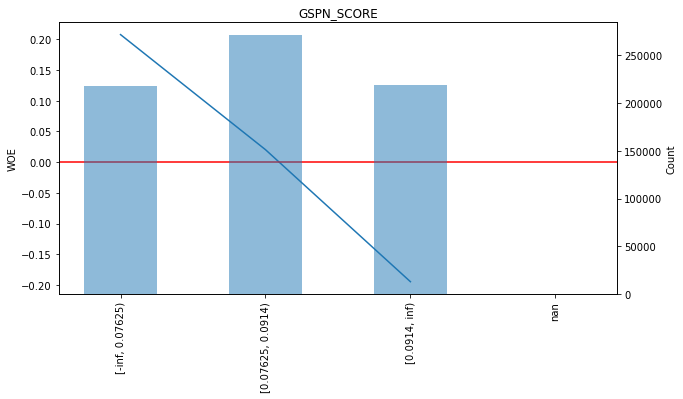

In [31]:
grouping.plot_bins(data=df_model[["GSPN_SCORE","RISK_FSTQPD60"]], cols_pred_num=['GSPN_SCORE'], cols_pred_cat=[],
                    mask=train_mask, col_target='RISK_FSTQPD60', output_folder=os.getcwd(), col_weight=None)

In [32]:
def iv_df(df=None,target=None, cluster_num=None):
    data=df.copy()
    data['target1'] = data[target]
    data['target0'] = 1-data[target]
    data['bucket'] = data[cluster_num]
    grouped = data.groupby('bucket', as_index = True)
    liftstable  = pd.DataFrame(grouped.count()[target])
    liftstable.columns = ['total']
    liftstable['bads']   = round(grouped.sum()['target1'])
    liftstable['goods'] = round(grouped.sum()['target0'])
    liftstable['bad_rate'] = liftstable['bads']/liftstable['total']
    
    liftstable['%base'] = (liftstable.total / data['target1'].count())
    liftstable = liftstable.sort_index(ascending=True).reset_index(drop = False)
    liftstable.rename(columns = {'index':"CLUSTER"},inplace = True)
    liftstable['cum%_base'] = (liftstable.total / data['target1'].count()).cumsum()
    liftstable['%bads'] = (liftstable['bads'] / data['target1'].sum())
    liftstable['%goods'] = (liftstable['goods'] / data['target0'].sum())
    liftstable['cum%_bads']=(liftstable['bads'] / data['target1'].sum()).cumsum()
    liftstable['cum%_goods']=(liftstable['bads'] / data['target0'].sum()).cumsum()
    liftstable['woe'] = np.log(liftstable['%goods'] / liftstable['%bads'])
    liftstable = liftstable.replace({'woe': {np.inf: 0, -np.inf: 0}})
    liftstable['IV'] = (liftstable['%goods'] - liftstable['%bads']) * liftstable["woe"]
    
    #Formating
    liftstable['%base']= liftstable['%base'].apply('{0:.2%}'.format)
    liftstable['%bads']= liftstable['%bads'].apply('{0:.2%}'.format)
    liftstable['%goods']= liftstable['%goods'].apply('{0:.2%}'.format)
    liftstable['cum%_bads']= liftstable['cum%_bads'].apply('{0:.2%}'.format)
    liftstable['cum%_goods']= liftstable['cum%_goods'].apply('{0:.2%}'.format)
    liftstable['cum%_base'] = liftstable['cum%_base'].apply('{0:.2%}'.format)
#     liftstable['bad_rate'] = liftstable['bad_rate'].apply('{0:.2%}'.format)

    pd.set_option('display.max_columns', 10)
    return(liftstable)

# Define GSPN Clusters

In [47]:
df_model["GSPN_VALUE"]=np.where(df_model["GSPN_SCORE"]<0.07625, 1,np.where(df_model["GSPN_SCORE"]<0.0914,2,3))

In [48]:
df_temp = df_model.dropna(subset = ["POS_GSPN_V2"])

In [49]:
from sklearn.metrics import roc_auc_score

iv_df1 = iv_df(df=df_model[train_mask],target = 'RISK_FSTQPD60', cluster_num = 'POS_GSPN_V2')

print("IV Value: ",format(np.sum(iv_df1["IV"])))
print("GINI Value: ", '{0:.2%}'.format(np.absolute(2*roc_auc_score(df_temp["RISK_FSTQPD60"],df_temp["POS_GSPN_V2"])-1)))

iv_df1[['bucket', 'total','bads','bad_rate','%bads', '%goods','woe','%base']]


IV Value:  0.020267720284858712
GINI Value:  6.62%


,bucket,total,bads,bad_rate,%bads,%goods,woe,%base
0,1.0,284207,11792.0,0.041491,34.60%,40.44%,0.155972,40.15%
1,2.0,370504,18800.0,0.050742,55.16%,52.20%,-0.055000,52.35%
2,3.0,52904,3482.0,0.065817,10.22%,7.34%,-0.331145,7.47%


In [50]:
from sklearn.metrics import roc_auc_score

iv_df1 = iv_df(df=df_model[train_mask],target = 'RISK_FSTQPD60', cluster_num = 'GSPN_VALUE')

print("IV Value: ",format(np.sum(iv_df1["IV"])))
print("GINI Value: ", '{0:.2%}'.format(np.absolute(2*roc_auc_score(df_temp["RISK_FSTQPD60"],df_temp["GSPN_VALUE"])-1)))

iv_df1[['bucket', 'total','bads','bad_rate','%bads', '%goods','woe','%base']]

IV Value:  0.025966860227486285
GINI Value:  7.97%


,bucket,total,bads,bad_rate,%bads,%goods,woe,%base
0,1,217424,8553.0,0.039338,25.09%,31.00%,0.211501,30.72%
1,2,271222,12801.0,0.047197,37.56%,38.36%,0.021133,38.32%
2,3,219143,12731.0,0.058094,37.35%,30.64%,-0.198099,30.96%


# Create POS Level Data(Monthly)

### Check Proportion in Current GSPN

In [51]:
df_temp = df_model.dropna(subset = ["POS_GSPN_V2"])

In [52]:
df_temp.POS_GSPN_V2.value_counts()/len(df_temp)*100

2.0    52.669019
1.0    39.945741
3.0     7.385175
8.0     0.000065
Name: POS_GSPN_V2, dtype: float64

In [53]:
df_temp["GSPN_SCORE"].quantile([0.40, 0.92])

0.40    0.079784
0.92    0.110312
Name: GSPN_SCORE, dtype: float64

# Define GSPN Clusters (Keeping Proportion Same as Current Setup)

In [54]:
df_model["GSPN_VALUE_1"]=np.where(df_model["GSPN_SCORE"]<0.079784, 1,np.where(df_model["GSPN_SCORE"]<0.110312,2,3))

In [81]:
df_temp = df_model.dropna(subset = ["POS_GSPN_V2"])

In [82]:
from sklearn.metrics import roc_auc_score

iv_df1 = iv_df(df=df_model[train_mask],target = 'RISK_FSTQPD60', cluster_num = 'POS_GSPN_V2')

print("IV Value: ",format(np.sum(iv_df1["IV"])))
print("GINI Value: ", '{0:.2%}'.format(np.absolute(2*roc_auc_score(df_temp["RISK_FSTQPD60"],df_temp["POS_GSPN_V2"])-1)))

iv_df1[['bucket', 'total','bads','bad_rate','%bads', '%goods','woe','%base']]


IV Value:  0.020267720284858712
GINI Value:  6.62%


,bucket,total,bads,bad_rate,%bads,%goods,woe,%base
0,1.0,284207,11792.0,0.041491,34.60%,40.44%,0.155972,40.15%
1,2.0,370504,18800.0,0.050742,55.16%,52.20%,-0.055000,52.35%
2,3.0,52904,3482.0,0.065817,10.22%,7.34%,-0.331145,7.47%


In [83]:
from sklearn.metrics import roc_auc_score

iv_df1 = iv_df(df=df_model[train_mask],target = 'RISK_FSTQPD60', cluster_num = 'GSPN_VALUE_1')

print("IV Value: ",format(np.sum(iv_df1["IV"])))
print("GINI Value: ", '{0:.2%}'.format(np.absolute(2*roc_auc_score(df_temp["RISK_FSTQPD60"],df_temp["GSPN_VALUE_1"])-1)))

iv_df1[['bucket', 'total','bads','bad_rate','%bads', '%goods','woe','%base']]

IV Value:  0.02194704505567941
GINI Value:  6.97%


,bucket,total,bads,bad_rate,%bads,%goods,woe,%base
0,1,286438,11764.0,0.041070,34.51%,40.77%,0.166607,40.47%
1,2,366488,18735.0,0.051120,54.97%,51.62%,-0.062834,51.78%
2,3,54863,3586.0,0.065363,10.52%,7.61%,-0.323729,7.75%


# MOM Gini, Distribution and Risk Comparison

In [84]:

gini_dic = {}
predictor_list = []
target_variable = 'RISK_FSTQPD60'
for x in df_temp["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "OLD_GSPN" not in gini_dic: 
            gini_dic["OLD_GSPN"] = []
        if "NEW_GSPN" not in gini_dic: 
            gini_dic["NEW_GSPN"] = []
        
        gini_dic["OLD_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["POS_GSPN_V2"])-1)*100)
        gini_dic["NEW_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GSPN_VALUE_1"])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in predictor_list:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             if y != 'FOUND_RESULT':
#                 try:
#                     gini_dic[y].append(((2*roc_auc_score(df[(df["MONTH_STR"]==x)&(df["FOUND_RESULT"]==1)][target_variable],df[(df["MONTH_STR"]==x)&(df["FOUND_RESULT"]==1)][y])-1)*100))
#                 except:
#                     gini_dic[y].append(0)
#             else:
#                 gini_dic[y].append(((2*roc_auc_score(df[df["MONTH_STR"]==x][target_variable],df[df["MONTH_STR"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

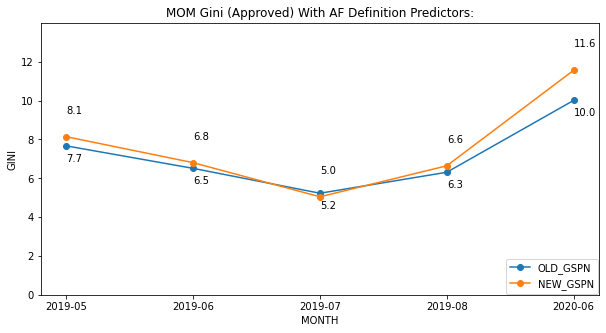

In [85]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["OLD_GSPN"], marker='o', scaley = False, label = "OLD_GSPN")
ax1.plot(gini_df["MONTH"],gini_df["NEW_GSPN"], marker='o', scaley = False, label = "NEW_GSPN")
# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["OLD_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["OLD_GSPN"][i]-0.8))
for i, txt in enumerate(gini_df["NEW_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["NEW_GSPN"][i]+1.2))
    
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,14)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,14,2))
ax1.set_title("MOM Gini (Approved) With AF Definition Predictors:")
plt.show()

# Only Phantomas Population

In [86]:
df_temp["FLAG_1PCT_PHANTOM"].value_counts()

0.0    1505455
1.0      26831
Name: FLAG_1PCT_PHANTOM, dtype: int64

In [87]:
df_temp = df_model.dropna(subset = ["POS_GSPN_V2"])
df_temp = df_temp[df_temp["FLAG_1PCT_PHANTOM"]==1.0  ]
gini_dic = {}
predictor_list = []
target_variable = 'RISK_FSTQPD60'
for x in df_temp["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "OLD_GSPN" not in gini_dic: 
            gini_dic["OLD_GSPN"] = []
        if "NEW_GSPN" not in gini_dic: 
            gini_dic["NEW_GSPN"] = []
        
        gini_dic["OLD_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["POS_GSPN_V2"])-1)*100)
        gini_dic["NEW_GSPN"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GSPN_VALUE_1"])-1)*100)
        gini_dic["MONTH"].append(x)
#         for y in predictor_list:
#             if y not in gini_dic:
#                   gini_dic[y] = []
#             if y != 'FOUND_RESULT':
#                 try:
#                     gini_dic[y].append(((2*roc_auc_score(df[(df["MONTH_STR"]==x)&(df["FOUND_RESULT"]==1)][target_variable],df[(df["MONTH_STR"]==x)&(df["FOUND_RESULT"]==1)][y])-1)*100))
#                 except:
#                     gini_dic[y].append(0)
#             else:
#                 gini_dic[y].append(((2*roc_auc_score(df[df["MONTH_STR"]==x][target_variable],df[df["MONTH_STR"]==x][y])-1)*100))
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

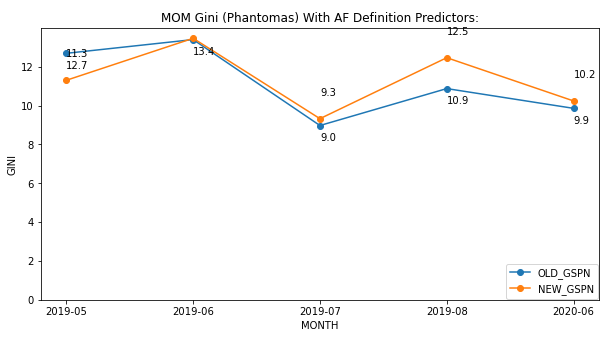

In [88]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["OLD_GSPN"], marker='o', scaley = False, label = "OLD_GSPN")
ax1.plot(gini_df["MONTH"],gini_df["NEW_GSPN"], marker='o', scaley = False, label = "NEW_GSPN")
# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["OLD_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["OLD_GSPN"][i]-0.8))
for i, txt in enumerate(gini_df["NEW_GSPN"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["NEW_GSPN"][i]+1.2))
    
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,14)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,14,2))
ax1.set_title("MOM Gini (Phantomas) With AF Definition Predictors:")
plt.show()

## Distribution

In [63]:
df_temp = df_model.dropna(subset = ["POS_GSPN_V2"])

In [64]:
df_temp.rename(columns = {"POS_GSPN_V2":"OLD_GSPN","GSPN_VALUE_1":"NEW_GSPN"}, inplace = True)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [65]:
df_summ_old = pd.DataFrame(df_temp.groupby(["MONTH","OLD_GSPN"])["SKP_CREDIT_CASE"].count()).reset_index()
df_summ_old = df_summ_old.pivot("MONTH","OLD_GSPN","SKP_CREDIT_CASE")
df_summ_old.columns = ['OLD_GSPN_' + str(x) for x in df_summ_old.columns]

for x in df_summ_old.index:
    tmp = df_summ_old.loc[x,].sum()
    for y in df_summ_old.columns:
        df_summ_old.loc[x,y] = round(df_summ_old.loc[x,y]/tmp*100,1)

In [66]:
df_summ_new = pd.DataFrame(df_temp.groupby(["MONTH","NEW_GSPN"])["SKP_CREDIT_CASE"].count()).reset_index()
df_summ_new = df_summ_new.pivot("MONTH","NEW_GSPN","SKP_CREDIT_CASE")
df_summ_new.columns = ['NEW_GSPN_' + str(x) for x in df_summ_new.columns]

for x in df_summ_new.index:
    tmp = df_summ_new.loc[x,].sum()
    for y in df_summ_new.columns:
        df_summ_new.loc[x,y] = round(df_summ_new.loc[x,y]/tmp*100,1)

In [67]:
df_summ_all = df_summ_old.merge(df_summ_new, left_index = True, right_index = True)

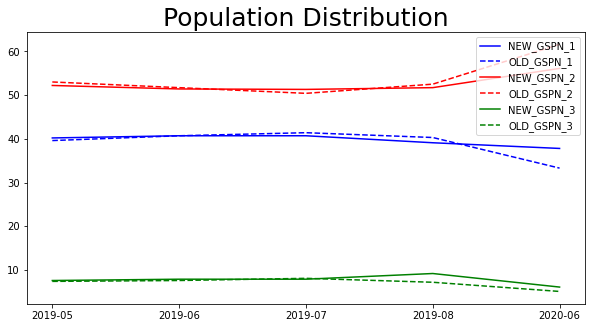

In [68]:
plt.figure(figsize=(10,5))
plt.plot(df_summ_new["NEW_GSPN_1"], color = 'b',label="NEW_GSPN_1")
plt.plot(df_summ_old["OLD_GSPN_1.0"],linestyle='--', color = 'b',label="OLD_GSPN_1")

plt.plot(df_summ_new["NEW_GSPN_2"], color = 'r',label="NEW_GSPN_2")
plt.plot(df_summ_old["OLD_GSPN_2.0"],linestyle='--', color = 'r',label="OLD_GSPN_2")

plt.plot(df_summ_new["NEW_GSPN_3"], color = 'g',label="NEW_GSPN_3")
plt.plot(df_summ_old["OLD_GSPN_3.0"],linestyle='--', color = 'g',label="OLD_GSPN_3")

plt.title('Population Distribution',fontsize=25)
plt.legend()

## Deinquency Rate

In [69]:
df_summ_old = pd.DataFrame(df_temp.groupby(["MONTH","OLD_GSPN"])['RISK_FSTQPD60',"RISK_AGRF120"].sum()).reset_index()
df_summ_old["FSTQPD60_%"] = round(df_summ_old["RISK_FSTQPD60"]/df_summ_old["RISK_AGRF120"],3)
df_summ_old = df_summ_old.pivot("MONTH","OLD_GSPN","FSTQPD60_%")
df_summ_old.columns = ['OLD_GSPN_' + str(x) for x in df_summ_old.columns]

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [70]:
df_summ_new = pd.DataFrame(df_temp.groupby(["MONTH","NEW_GSPN"])['RISK_FSTQPD60',"RISK_AGRF120"].sum()).reset_index()
df_summ_new["FSTQPD60_%"] = round(df_summ_new["RISK_FSTQPD60"]/df_summ_new["RISK_AGRF120"],3)
df_summ_new = df_summ_new.pivot("MONTH","NEW_GSPN","FSTQPD60_%")
df_summ_new.columns = ['NEW_GSPN_' + str(x) for x in df_summ_new.columns]


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [71]:
df_summ_all = df_summ_old.merge(df_summ_new, left_index = True, right_index = True)

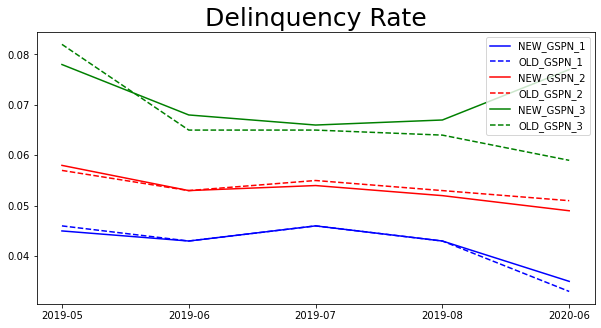

In [72]:
plt.figure(figsize=(10,5))
plt.plot(df_summ_new["NEW_GSPN_1"], color = 'b',label="NEW_GSPN_1")
plt.plot(df_summ_old["OLD_GSPN_1.0"],linestyle='--', color = 'b',label="OLD_GSPN_1")

plt.plot(df_summ_new["NEW_GSPN_2"], color = 'r',label="NEW_GSPN_2")
plt.plot(df_summ_old["OLD_GSPN_2.0"],linestyle='--', color = 'r',label="OLD_GSPN_2")

plt.plot(df_summ_new["NEW_GSPN_3"], color = 'g',label="NEW_GSPN_3")
plt.plot(df_summ_old["OLD_GSPN_3.0"],linestyle='--', color = 'g',label="OLD_GSPN_3")

plt.title('Delinquency Rate',fontsize=25)
plt.legend()

# Pivot Analysis

In [73]:
df_summ = df_temp.groupby(["OLD_GSPN","NEW_GSPN"])["SKP_CREDIT_CASE"].count().reset_index()

print("TOTAL CASE COUNT")
df_summ.pivot(index="OLD_GSPN",columns = "NEW_GSPN", values="SKP_CREDIT_CASE")

TOTAL CASE COUNT


NEW_GSPN,1,2,3
OLD_GSPN,,,
1.0,446743.0,163561.0,1779.0
2.0,161713.0,568545.0,76782.0
3.0,4479.0,64632.0,44051.0
8.0,NaN,1.0,NaN


In [74]:
df_summ["CASE_%"] = round(df_summ["SKP_CREDIT_CASE"]/(df_summ["SKP_CREDIT_CASE"].sum())*100,0)

print("% Cases")
df_summ.pivot(index="OLD_GSPN",columns = "NEW_GSPN", values="CASE_%")

% Cases


NEW_GSPN,1,2,3
OLD_GSPN,,,
1.0,29.0,11.0,0.0
2.0,11.0,37.0,5.0
3.0,0.0,4.0,3.0
8.0,NaN,0.0,NaN


In [75]:
df_summ = df_temp.groupby(["OLD_GSPN","NEW_GSPN"])[["RISK_AGRF120","RISK_FSTQPD60"]].sum().reset_index()

df_summ["FSTQPD60_%"] = round(df_summ["RISK_FSTQPD60"]/df_summ["RISK_AGRF120"]*100,2)

print("FSTQPD60_%")
df_summ.pivot(index="OLD_GSPN",columns = "NEW_GSPN", values="FSTQPD60_%")

FSTQPD60_%


NEW_GSPN,1,2,3
OLD_GSPN,,,
1.0,4.17,4.84,4.84
2.0,4.81,5.40,6.74
3.0,5.35,6.50,7.52
8.0,NaN,0.00,NaN


# Archieve

# Model with AF Predictors (Binomial Distribution)

In [87]:
x_columns = ["CASE_COUNT","RISK_FPD30_BINOM","RISK_SPD30_BINOM","RISK_TPD30_BINOM","RISK_4PD30_BINOM", "COMBINED_SCORE_KNN_EXI",
            "COMBINED_SCORE_KNN_NTC","AP_POS_TYPE","Aldi_POS_TYPE","Satellite_POS_TYPE","UDAAN_POS_TYPE"]
y_column = "RISK_FSTQPD60"

print("Event rate in train set :", '{:,.2%}'.format(sum(df_train[y_column]) / len(df_train[y_column])))
print("Train set shape:",df_train[x_columns].shape)
print("Event rate in test set :", '{:,.2%}'.format(sum(df_test[y_column]) / len(df_test[y_column])))
print("Train set shape:",df_test[x_columns].shape)


Event rate in train set : 4.82%


KeyError: "['RISK_TPD30_BINOM', 'RISK_4PD30_BINOM', 'RISK_FPD30_BINOM', 'RISK_SPD30_BINOM'] not in index"

## L1 Penalty Hyper Parameter Optimization

In [40]:
param_grid = {'C':np.exp(np.arange(-3,2,0.01))}

In [41]:
kfolds = StratifiedKFold(3, random_state=1)
comb=LogisticRegression(penalty = 'l1')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['roc_auc'], n_iter = 10,
    cv=kfolds.split(df_train[x_columns],df_train[y_column]), verbose=0, random_state=1,
    refit = 'roc_auc', return_train_score=True, error_score = 0)

In [42]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")

search_time_start = time.time()
rcv.fit(df_train[x_columns], df_train[y_column])
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 

Randomized search..


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Lo

Randomized search time: 2868.19940328598


{'C': 1.3231298123373445}


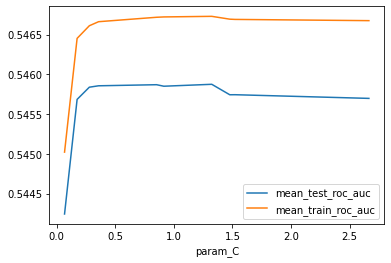

In [43]:
tmp1= pd.DataFrame(dic)[["param_C","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_C')
tmp1.plot(x="param_C")
print(params)

## Logistic With optimized Hyperparameters 

In [44]:
from sklearn.linear_model import LogisticRegression

bst = LogisticRegression(penalty = 'l1', C=params['C'])

bst.fit(df_train[x_columns], df_train[y_column])

ypred_train = bst.predict_proba(df_train[x_columns])[:, 1]
ypred_test = bst.predict_proba(df_test[x_columns])[:, 1]

print("Train GINI(COMBINED_SCORE) %.3f" % (2*roc_auc_score(df_train[y_column], ypred_train)-1))
print("Test GINI(COMBINED_SCORE) %.3f" % (2*roc_auc_score(df_test[y_column], ypred_test)-1))


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train GINI(COMBINED_SCORE) 0.093
Test GINI(COMBINED_SCORE) 0.089


In [45]:
pd.DataFrame({"column":x_columns,"coeffecient":bst.coef_[0]})

,column,coeffecient
0,RISK_FPD30_BINOM,-0.150784
1,RISK_SPD30_BINOM,-0.084651
2,RISK_TPD30_BINOM,-0.063722
3,RISK_4PD30_BINOM,-0.237050
4,COMBINED_SCORE_KNN_EXI,0.703443
5,COMBINED_SCORE_KNN_NTC,7.107641
6,AP_POS_TYPE,-2.620844
7,Aldi_POS_TYPE,-2.621491
8,Satellite_POS_TYPE,-2.587513
9,UDAAN_POS_TYPE,0.000000


In [46]:
df_model["GSPN_SCORE_1"] =  bst.predict_proba(df_model[x_columns])[:, 1]